# Module 11 - Convolutional Neural Networks - Lab 3

<table class="tfo-notebook-buttons" align="left">
 <td>
 <a target="_blank" href="https://colab.research.google.com/drive/1OOG0_aCrwPIIb8-M0al0zcHTX05YMOs0?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
 </td>
 <td>
 <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/blob/main/CNN/cnn_lab3.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
 </td>
</table>
<br>
<br>
<br>

---
Module Coordinator: Ekta Gavas

Email: ekta.gavas@research.iiit.ac.in

## Description
---
In this lab exercise, we will study image classification problem using CNNs with RGB images. We will implement a basic CNN model for classifying CIFAR10 images and train it end-to-end and evaluate our model on test data. We will then visualize the kernels and intermediate feature maps i.e the output of intermediate layers.

## Starter Code
---
To make your task easier, we provide you the starter code to perform the lab exercises. It is expected that you should try to understand what the code does and analyze the output. We will be using Pytorch framework for the implementation of this lab. The training hyperparameters that are used in the code may not be the best to minimize training time according to lab scope. 

## CIFAR10 Image classification

**We will do the following steps in order:**
1.   Load and normalize CIFAR10 training and test datasets using torchvision and visualize few samples
2.   Define the CNN model
3.   Define a loss function and optimizer
4.   Train the network on the training data
5.   Evaluate the network on the test data

In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Load CIFAR10 data
We will use the [CIFAR10 dataset](https://pytorch.org/vision/stable/datasets.html#cifar) from torchvision Pytorch and setup the train and test dataloaders.

In [ ]:
# Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


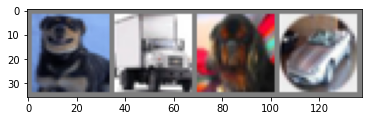

  dog truck   dog   car


In [ ]:
# Helper function to show an image
def plot_image(img):
    img = img / 2 + 0.5                         # unnormalize the image
    npimg = img.numpy()                         # torch to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # as torch image is (C, H, W)
    plt.show()


# get some random training images from dataloader
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plot images
plot_image(torchvision.utils.make_grid(images[:4]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Helper functions for training/testing

In [ ]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           

      # Put data on devices
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values 
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [ ]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          # Calculate outputs by running images through the network
          outputs = model(images)
          # The class with the highest value is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

### Define the model

In [ ]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### Define loss function

In [ ]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

### Define optimizer

In [ ]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

### Training

In [ ]:
# Accuracy on test data before training
test_model(model, testloader)

Accuracy of the network: 10 %


In [ ]:
num_epochs = 15  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/15, Loss: 0.0130, Accuracy: 39.1340
Epoch 2/15, Loss: 0.0094, Accuracy: 57.0100
Epoch 3/15, Loss: 0.0079, Accuracy: 64.7160
Epoch 4/15, Loss: 0.0067, Accuracy: 69.6920
Epoch 5/15, Loss: 0.0058, Accuracy: 73.8220
Epoch 6/15, Loss: 0.0050, Accuracy: 77.1860
Epoch 7/15, Loss: 0.0043, Accuracy: 80.6160
Epoch 8/15, Loss: 0.0037, Accuracy: 83.0140
Epoch 9/15, Loss: 0.0034, Accuracy: 84.7360
Epoch 10/15, Loss: 0.0030, Accuracy: 86.8540
Epoch 11/15, Loss: 0.0027, Accuracy: 88.0440
Epoch 12/15, Loss: 0.0025, Accuracy: 89.1700
Epoch 13/15, Loss: 0.0022, Accuracy: 90.3920
Epoch 14/15, Loss: 0.0021, Accuracy: 91.0540
Epoch 15/15, Loss: 0.0020, Accuracy: 91.4140


Plot training plots

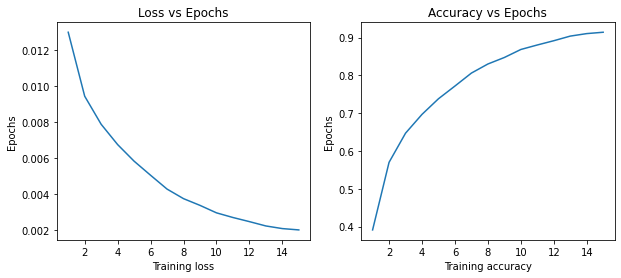

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

As you can see the model has not converged. Experiment with the hyper-parameters like learning rate, epochs, and also optimizers. What change did you observe in the performance?

### Evaluate model

In [ ]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 65 %


The test accuracy is very less compared to training accuracy. The model doesn't perform equally well on unseen data. Let's see the predictions on few test images.

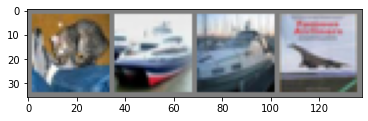

GroundTruth:    cat  ship  ship plane


In [ ]:
# print few test images

dataiter = iter(testloader)
images, labels = dataiter.next()

plot_image(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# Get predictions on test images
outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


Let's see the test accuracy for each class in the dataset

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 75.6 %
Accuracy for class car   is: 73.5 %
Accuracy for class bird  is: 48.9 %
Accuracy for class cat   is: 54.3 %
Accuracy for class deer  is: 61.9 %
Accuracy for class dog   is: 48.2 %
Accuracy for class frog  is: 64.4 %
Accuracy for class horse is: 72.4 %
Accuracy for class ship  is: 78.3 %
Accuracy for class truck is: 80.4 %


## Feature map visualization

Save the conv layers and their weights

In [ ]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the conv layers in this list
# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


In [ ]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1)) ====> SHAPE: torch.Size([16, 3, 3, 3])
CONV: Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([32, 16, 5, 5])


### Visualize the CONV layer filters

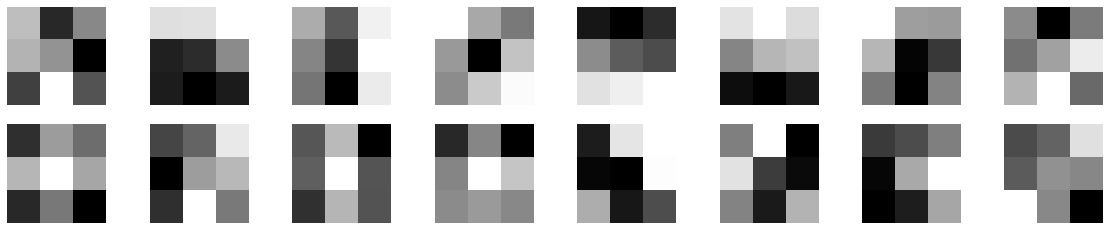

In [ ]:
# Visualize the conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8)
    plt.imshow(filter[0, :, :].data.cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

### Visualize filter outputs on an image
Get an image from test dataset

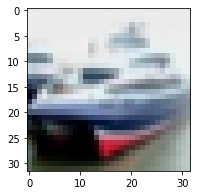

ship


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images.data[1:2]
fig = plt.figure(figsize=(3,3))
plot_image(img.reshape((3,32,32)))
print(classes[labels.data[1]])

Forward pass the image through saved conv layers

In [ ]:
results = [conv_layers[0](img.to(device))]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

Visualize features from each layer 

Layer output size: torch.Size([16, 30, 30])
Layer 0 feature maps...


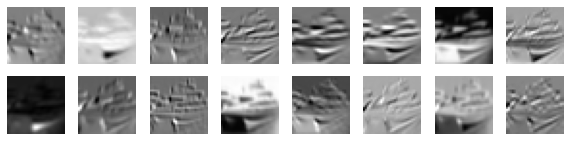

Layer output size: torch.Size([32, 26, 26])
Layer 1 feature maps...


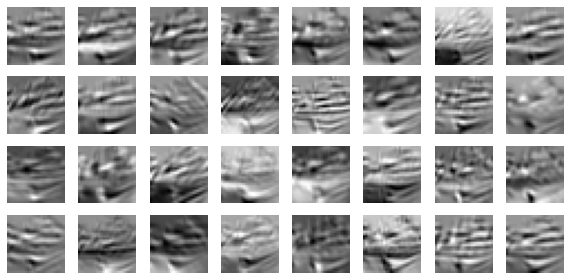

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(10, 10))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print('Layer output size:', layer_viz.size())
    for i, filter in enumerate(layer_viz):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().numpy(), cmap='gray')
        plt.axis("off")
    print(f"Layer {num_layer} feature maps...")
    plt.show()
    plt.close()

As you can observe, the filters in first conv layer (Layer 0) detect low level features whereas second conv layer (Layer 1) detect more complex features. Thus, as you move towards the output layer, the features become more complex.

## Exercises

Q 1: Calculate the total number of parameters in the above network (We have a bias parameter for each filter).

Answer:

Q 2: What is the size of the feature map obtained for a given input image (n x n) convolved with kernel (k x k), stride (s), and padding (p)?

Answer:

Q 3: Does the size of the feature map always reduce upon applying the filters? Explain why or why not.

Answer:

Q 4: Can we use CNN to perform Dimensionality Reduction? If Yes, then which layer is responsible for dimensionality reduction particularly in CNN? 

Answer:

Q 5: Which of the following statements is true when you use 1×1 convolutions in a CNN?

A. It can help in dimensionality reduction

B. It can be used for feature pooling

C. It suffers less overfitting due to small kernel size

D. All of the above

Answer:

## References and Additional Resources

*   [Training a classifier tutorial - Pytorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier)
*   [Visualizing Filters and Feature Maps in Convolutional Neural Networks using PyTorch](https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/)
*   [ConvNetJS CIFAR10 Demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html)


